C:\Users\HP Victus\AppData\Local\Temp\ipykernel_15432\846827267.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['State'] = discretized.dot(np.array([10 ** i for i in range(discretized.shape[1])]))



[Evaluation Finale]
Rendement cumule: 76.16 $
Sharpe Ratio: 1.69
Max Drawdown: 40.21 $


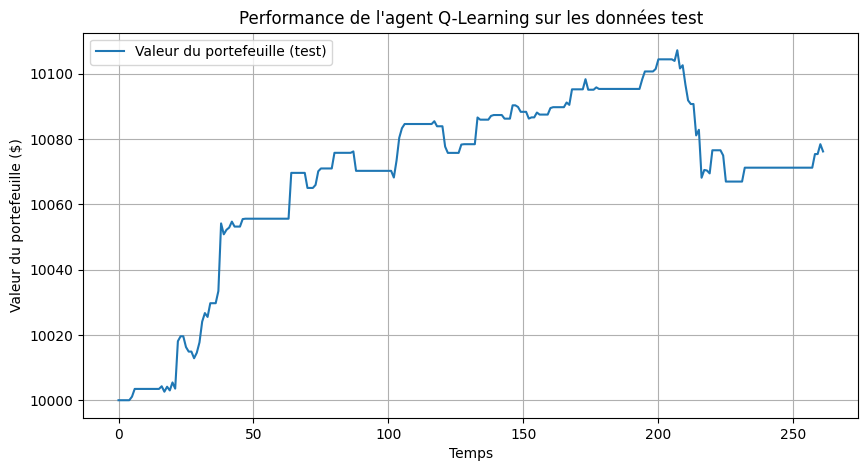

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import KBinsDiscretizer

# Chargement des données
apple_data = pd.read_csv("data/apple_data_clean.csv")
apple_data = apple_data.iloc[::-1].reset_index(drop=True)  # Remettre dans l'ordre chronologique

# Création de l'état: variation de prix sur n jours
def create_state_features(data, window=3):
    data['Return'] = data['Close'].pct_change()
    for i in range(1, window + 1):
        data[f'Return_t-{i}'] = data['Return'].shift(i)
    return data.dropna()

data = create_state_features(apple_data)

# Discrétisation cohérente sur tout le dataset
state_features = [col for col in data.columns if "Return_t" in col]
scaler = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
discretized = scaler.fit_transform(data[state_features]).astype(int)

# Encodage d'état unique par une combinaison linéaire des colonnes (base 10)
data['State'] = discretized.dot(np.array([10 ** i for i in range(discretized.shape[1])]))

# Paramètres RL
actions = {0: 'Hold', 1: 'Buy', 2: 'Sell'}
n_actions = len(actions)
n_states = data['State'].max() + 1  # Pour couvrir tous les états possibles

epsilon = 0.1
gamma = 0.95
alpha = 0.1

# Initialisation de la Q-table
Q_table = np.zeros((n_states, n_actions))

# Environnement de trading
def simulate_episode(data, Q_table, train=True):
    cash = 10000
    stock = 0
    portfolio_values = []

    for t in range(len(data) - 1):
        state = int(data.iloc[t]['State'])
        price = data.iloc[t]['Close']

        # Politique ε-greedy
        if train and np.random.rand() < epsilon:
            action = np.random.choice(n_actions)
        else:
            action = np.argmax(Q_table[state])

        # Appliquer l'action
        reward = 0
        if action == 1 and cash >= price:  # Buy
            stock += 1
            cash -= price
        elif action == 2 and stock > 0:  # Sell
            stock -= 1
            cash += price

        next_price = data.iloc[t+1]['Close']
        next_state = int(data.iloc[t+1]['State'])

        next_portfolio = cash + stock * next_price
        current_portfolio = cash + stock * price
        reward = next_portfolio - current_portfolio

        if train:
            best_next_action = np.max(Q_table[next_state])
            Q_table[state, action] += alpha * (reward + gamma * best_next_action - Q_table[state, action])

        portfolio_values.append(current_portfolio)

    return portfolio_values

# Séparation entrainement / test
split = int(len(data) * 0.8)
data_train = data.iloc[:split].reset_index(drop=True)
data_test = data.iloc[split:].reset_index(drop=True)

# Entraînement
n_episodes = 100
performance_train = []

for ep in range(n_episodes):
    values = simulate_episode(data_train, Q_table, train=True)
    performance_train.append(values[-1])

# Test
values_test = simulate_episode(data_test, Q_table, train=False)

# Évaluation
returns = np.diff(values_test) / values_test[:-1]
cum_return = values_test[-1] - values_test[0]
sharpe = np.mean(returns) / np.std(returns) * np.sqrt(252) if np.std(returns) > 0 else 0
drawdown = np.max(np.maximum.accumulate(values_test) - values_test)

print(f"\n[Evaluation Finale]")
print(f"Rendement cumule: {cum_return:.2f} $")
print(f"Sharpe Ratio: {sharpe:.2f}")
print(f"Max Drawdown: {drawdown:.2f} $")

# Courbes de performance
plt.figure(figsize=(10,5))
plt.plot(values_test, label="Valeur du portefeuille (test)")
plt.title("Performance de l'agent Q-Learning sur les données test")
plt.xlabel("Temps")
plt.ylabel("Valeur du portefeuille ($)")
plt.legend()
plt.grid()
plt.show()


C:\Users\HP Victus\AppData\Local\Temp\ipykernel_15432\4003227807.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['State'] = discretized.dot(np.array([10 ** i for i in range(discretized.shape[1])]))



[Evaluation Finale - Améliorée + Visualisation des Trades]
Rendement cumule: 4.28 $
Sharpe Ratio: 0.03
Max Drawdown: 547.28 $


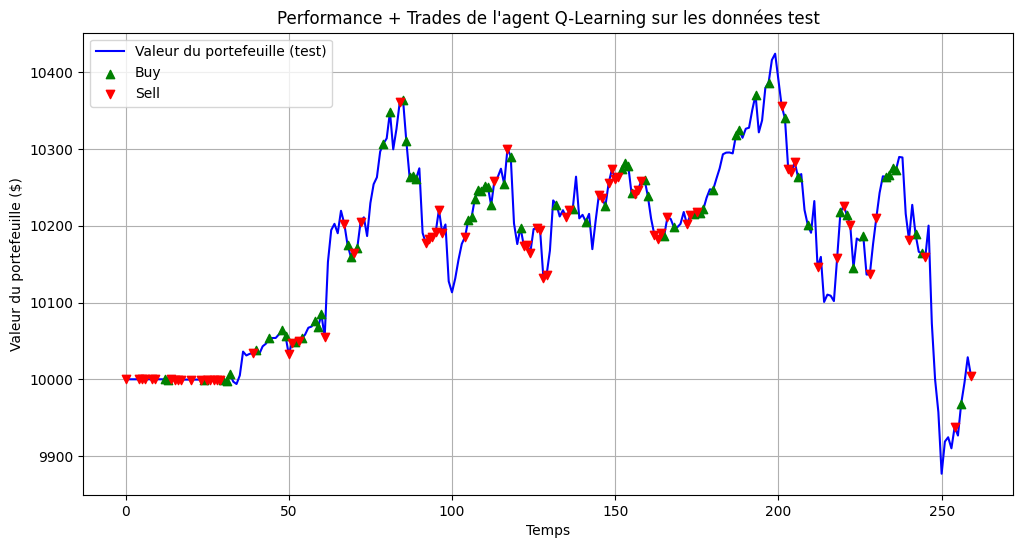

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import KBinsDiscretizer

# Chargement des données
apple_data = pd.read_csv("data/apple_data_clean.csv")
apple_data = apple_data.iloc[::-1].reset_index(drop=True)

# Ajout d'indicateurs techniques (RSI et moyenne mobile)
def compute_indicators(data):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
    rs = gain / loss
    data['RSI'] = 100 - (100 / (1 + rs))
    data['SMA_10'] = data['Close'].rolling(window=10).mean()
    data['SMA_ratio'] = data['Close'] / data['SMA_10']
    return data

# Création de l'état: variation de prix + indicateurs
def create_state_features(data, window=3):
    data = compute_indicators(data)
    data['Return'] = data['Close'].pct_change()
    for i in range(1, window + 1):
        data[f'Return_t-{i}'] = data['Return'].shift(i)
    return data.dropna()

data = create_state_features(apple_data)

# Discrétisation de l'espace d'état
state_features = ['RSI', 'SMA_ratio'] + [col for col in data.columns if "Return_t" in col]
scaler = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
discretized = scaler.fit_transform(data[state_features]).astype(int)
data['State'] = discretized.dot(np.array([10 ** i for i in range(discretized.shape[1])]))

# Paramètres Q-Learning
actions = {0: 'Hold', 1: 'Buy', 2: 'Sell'}
n_actions = len(actions)
n_states = data['State'].max() + 1

epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
gamma = 0.95
alpha = 0.1
Q_table = np.zeros((n_states, n_actions))

# Simulation d'un épisode avec enregistrement des actions
def simulate_episode(data, Q_table, epsilon, train=True, log_actions=False):
    cash = 10000
    stock = 0
    portfolio_values = []
    action_log = []

    for t in range(len(data) - 1):
        state = int(data.iloc[t]['State'])
        price = data.iloc[t]['Close']

        if train and np.random.rand() < epsilon:
            action = np.random.choice(n_actions)
        else:
            action = np.argmax(Q_table[state])

        reward = 0
        if action == 1 and cash >= price:
            stock += 1
            cash -= price
        elif action == 2 and stock > 0:
            stock -= 1
            cash += price

        next_price = data.iloc[t+1]['Close']
        next_state = int(data.iloc[t+1]['State'])

        next_portfolio = cash + stock * next_price
        current_portfolio = cash + stock * price
        reward = next_portfolio - current_portfolio

        if train:
            best_next_action = np.max(Q_table[next_state])
            Q_table[state, action] += alpha * (reward + gamma * best_next_action - Q_table[state, action])

        portfolio_values.append(current_portfolio)
        if log_actions:
            action_log.append((t, action, price))

    if log_actions:
        return portfolio_values, action_log
    else:
        return portfolio_values

# Séparation train/test
split = int(len(data) * 0.8)
data_train = data.iloc[:split].reset_index(drop=True)
data_test = data.iloc[split:].reset_index(drop=True)

# Entraînement
n_episodes = 100
epsilon_current = epsilon
for ep in range(n_episodes):
    simulate_episode(data_train, Q_table, epsilon_current, train=True)
    epsilon_current = max(epsilon_min, epsilon_current * epsilon_decay)

# Test avec log des actions
values_test, actions_test = simulate_episode(data_test, Q_table, epsilon=0.0, train=False, log_actions=True)

# Évaluation
returns = np.diff(values_test) / values_test[:-1]
cum_return = values_test[-1] - values_test[0]
sharpe = np.mean(returns) / np.std(returns) * np.sqrt(252) if np.std(returns) > 0 else 0
drawdown = np.max(np.maximum.accumulate(values_test) - values_test)

print(f"\n[Evaluation Finale - Améliorée + Visualisation des Trades]")
print(f"Rendement cumule: {cum_return:.2f} $")
print(f"Sharpe Ratio: {sharpe:.2f}")
print(f"Max Drawdown: {drawdown:.2f} $")

# Courbe de performance + positions
plt.figure(figsize=(12,6))
plt.plot(values_test, label="Valeur du portefeuille (test)", color='blue')

buy_points = [t for (t, a, p) in actions_test if a == 1]
buy_prices = [p for (t, a, p) in actions_test if a == 1]
sell_points = [t for (t, a, p) in actions_test if a == 2]
sell_prices = [p for (t, a, p) in actions_test if a == 2]

plt.scatter(buy_points, [values_test[t] for t in buy_points], marker='^', color='green', label='Buy', zorder=5)
plt.scatter(sell_points, [values_test[t] for t in sell_points], marker='v', color='red', label='Sell', zorder=5)

plt.title("Performance + Trades de l'agent Q-Learning sur les données test")
plt.xlabel("Temps")
plt.ylabel("Valeur du portefeuille ($)")
plt.legend()
plt.grid()
plt.show()

Episode 1/100 - Profit: -0.20 - Epsilon: 0.9950
Episode 2/100 - Profit: -0.04 - Epsilon: 0.9900
Episode 3/100 - Profit: 0.33 - Epsilon: 0.9851
Episode 4/100 - Profit: 0.24 - Epsilon: 0.9801
Episode 5/100 - Profit: -0.02 - Epsilon: 0.9752
Episode 6/100 - Profit: 0.45 - Epsilon: 0.9704
Episode 7/100 - Profit: 0.21 - Epsilon: 0.9655
Episode 8/100 - Profit: 0.54 - Epsilon: 0.9607
Episode 9/100 - Profit: 0.08 - Epsilon: 0.9559
Episode 10/100 - Profit: 0.34 - Epsilon: 0.9511
Episode 11/100 - Profit: 0.66 - Epsilon: 0.9464
Episode 12/100 - Profit: 0.70 - Epsilon: 0.9416
Episode 13/100 - Profit: 0.15 - Epsilon: 0.9369
Episode 14/100 - Profit: 0.35 - Epsilon: 0.9322
Episode 15/100 - Profit: 0.51 - Epsilon: 0.9276
Episode 16/100 - Profit: 0.26 - Epsilon: 0.9229
Episode 17/100 - Profit: 0.10 - Epsilon: 0.9183
Episode 18/100 - Profit: 0.58 - Epsilon: 0.9137
Episode 19/100 - Profit: 0.28 - Epsilon: 0.9092
Episode 20/100 - Profit: 0.43 - Epsilon: 0.9046
Episode 21/100 - Profit: 0.17 - Epsilon: 0.900

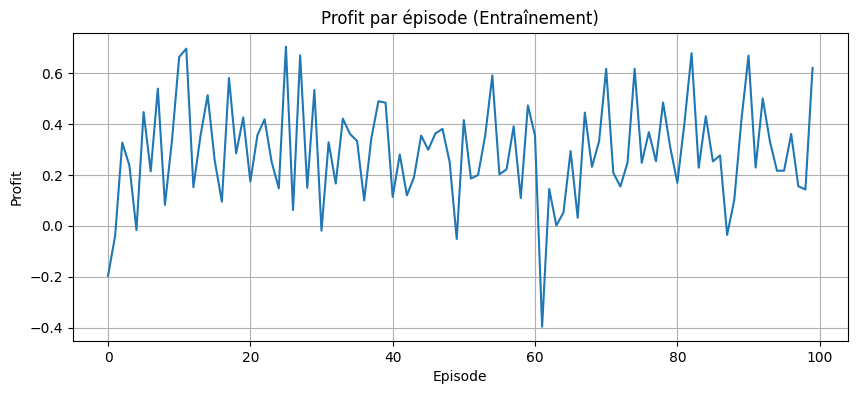

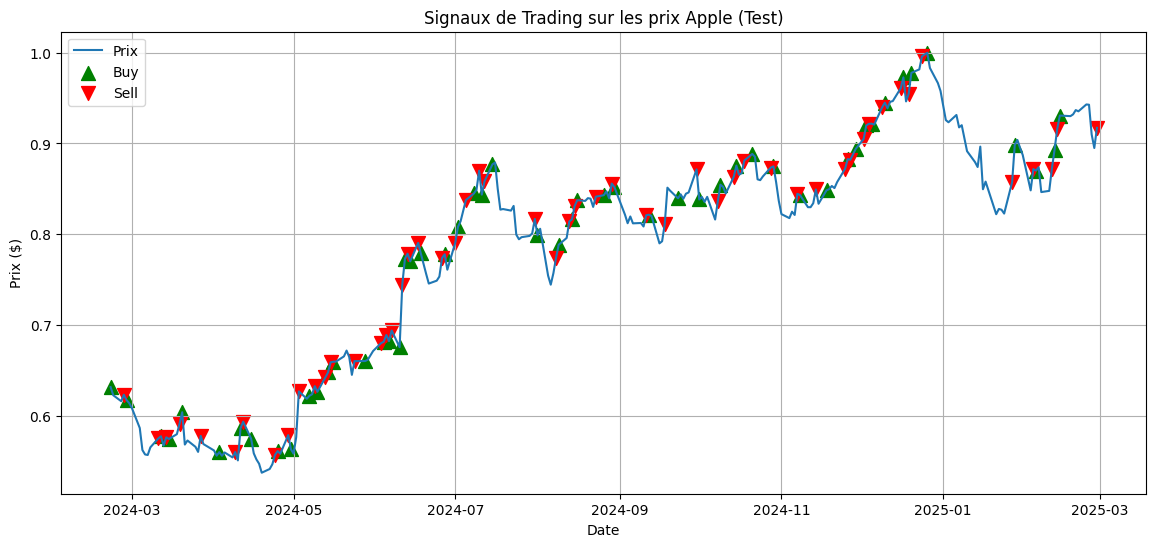

In [42]:
# Q-Learning Trading Agent for Apple Stock (Version enrichie)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

# -----------------------------
# 1. PREPARATION DES DONNEES
# -----------------------------
data = pd.read_csv('data/apple_data_normalized.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.sort_values('Date', inplace=True)
data.reset_index(drop=True, inplace=True)

# Ajout de features techniques
# Variation journalière en pourcentage
data['Return'] = data['Adj Close'].pct_change()
# Moyennes mobiles
data['MA5'] = data['Adj Close'].rolling(window=5).mean()
data['MA20'] = data['Adj Close'].rolling(window=20).mean()
data['MA_Signal'] = (data['MA5'] > data['MA20']).astype(int)

# RSI
delta = data['Adj Close'].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
data['RSI'] = 100 - (100 / (1 + rs))

# Bollinger Bands
rolling_mean = data['Adj Close'].rolling(window=20).mean()
rolling_std = data['Adj Close'].rolling(window=20).std()
data['Bollinger_Upper'] = rolling_mean + 2 * rolling_std
data['Bollinger_Lower'] = rolling_mean - 2 * rolling_std

# MACD
exp1 = data['Adj Close'].ewm(span=12, adjust=False).mean()
exp2 = data['Adj Close'].ewm(span=26, adjust=False).mean()
data['MACD'] = exp1 - exp2

# Volume normalisé
data['Volume_Norm'] = (data['Volume'] - data['Volume'].rolling(20).mean()) / data['Volume'].rolling(20).std()

# Nettoyage
data.dropna(inplace=True)

# Discrétisation des returns (buckets)
def discretize_return(ret):
    if ret > 0.01:
        return 2
    elif ret < -0.01:
        return 0
    else:
        return 1

data['Return_Class'] = data['Return'].apply(discretize_return)

# -----------------------------
# 2. ENVIRONNEMENT DE TRADING
# -----------------------------
class TradingEnvironment:
    def __init__(self, data):
        self.data = data
        self.n_steps = len(data)
        self.reset()

    def reset(self):
        self.current_step = 0
        self.position = 0
        self.buy_price = 0.0
        self.total_profit = 0.0
        self.history = []
        self.profits = []
        return self._get_state()

    def _get_state(self):
        row = self.data.iloc[self.current_step]
        return (row['Return_Class'], row['MA_Signal'], self.position, 
                int(row['RSI'] > 70), int(row['RSI'] < 30),
                int(row['Adj Close'] > row['Bollinger_Upper']),
                int(row['Adj Close'] < row['Bollinger_Lower']),
                int(row['MACD'] > 0),
                int(row['Volume_Norm'] > 1))

    def step(self, action):
        done = False
        reward = 0
        price = self.data.iloc[self.current_step]['Adj Close']

        if action == 1 and self.position == 0:
            self.position = 1
            self.buy_price = price
            self.history.append((self.current_step, 'BUY', price))
        elif action == 2 and self.position == 1:
            profit = price - self.buy_price
            reward = profit
            self.total_profit += profit
            self.profits.append(profit)
            self.position = 0
            self.history.append((self.current_step, 'SELL', price))

        self.current_step += 1
        if self.current_step >= self.n_steps:
            done = True
            return None, reward, done
        else:
            return self._get_state(), reward, done

# -----------------------------
# 3. AGENT Q-LEARNING
# -----------------------------
class QLearningAgent:
    def __init__(self, state_size, action_size, alpha=0.1, gamma=0.95, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        self.q_table = {}
        self.state_size = state_size
        self.action_size = action_size
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min

    def get_qs(self, state):
        if state not in self.q_table:
            self.q_table[state] = np.zeros(self.action_size)
        return self.q_table[state]

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.action_size)
        return np.argmax(self.get_qs(state))

    def learn(self, state, action, reward, next_state):
        old_q = self.get_qs(state)[action]
        future_q = np.max(self.get_qs(next_state)) if next_state is not None else 0
        new_q = old_q + self.alpha * (reward + self.gamma * future_q - old_q)
        self.q_table[state][action] = new_q

    def decay_epsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# -----------------------------
# 4. ENTRAINEMENT
# -----------------------------
split_idx = int(len(data) * 0.8)
train_data = data.iloc[:split_idx].copy()
test_data = data.iloc[split_idx:].copy()

env = TradingEnvironment(train_data)
agent = QLearningAgent(state_size=9, action_size=3)

n_episodes = 100
profits = []

for episode in range(n_episodes):
    state = env.reset()
    total_reward = 0

    while True:
        action = agent.choose_action(state)
        next_state, reward, done = env.step(action)
        if next_state is not None:
            agent.learn(state, action, reward, next_state)
            state = next_state
        if done:
            break

    agent.decay_epsilon()
    profits.append(env.total_profit)
    print(f"Episode {episode+1}/{n_episodes} - Profit: {env.total_profit:.2f} - Epsilon: {agent.epsilon:.4f}")

# -----------------------------
# 5. EVALUATION ET VISUALISATION
# -----------------------------
test_env = TradingEnvironment(test_data)
state = test_env.reset()

while True:
    action = np.argmax(agent.get_qs(state))
    next_state, reward, done = test_env.step(action)
    if next_state is not None:
        state = next_state
    if done:
        break

# Metrics
returns = pd.Series(test_env.profits)
cumulative_return = test_env.total_profit
sharpe_ratio = returns.mean() / returns.std() * np.sqrt(252) if len(returns) > 1 else 0
max_drawdown = (np.maximum.accumulate(returns.cumsum()) - returns.cumsum()).max()

print("\n--- Evaluation Finale ---")
print(f"Profit total test: {cumulative_return:.2f}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Max Drawdown: {max_drawdown:.2f}")

# Courbe d'apprentissage
plt.figure(figsize=(10, 4))
plt.plot(profits)
plt.title("Profit par épisode (Entraînement)")
plt.xlabel("Episode")
plt.ylabel("Profit")
plt.grid()
plt.show()

# Courbe de prix avec signaux d'achat/vente
plt.figure(figsize=(14, 6))
plt.plot(test_data['Date'].values, test_data['Adj Close'].values, label='Prix')

buy_signals = [(idx, price) for idx, action, price in test_env.history if action == 'BUY']
sell_signals = [(idx, price) for idx, action, price in test_env.history if action == 'SELL']

if buy_signals:
    buy_idx, buy_price = zip(*buy_signals)
    plt.scatter(test_data.iloc[list(buy_idx)]['Date'], buy_price, marker='^', color='g', label='Buy', s=100)
if sell_signals:
    sell_idx, sell_price = zip(*sell_signals)
    plt.scatter(test_data.iloc[list(sell_idx)]['Date'], sell_price, marker='v', color='r', label='Sell', s=100)

plt.title("Signaux de Trading sur les prix Apple (Test)")
plt.xlabel("Date")
plt.ylabel("Prix ($)")
plt.legend()
plt.grid()
plt.show()


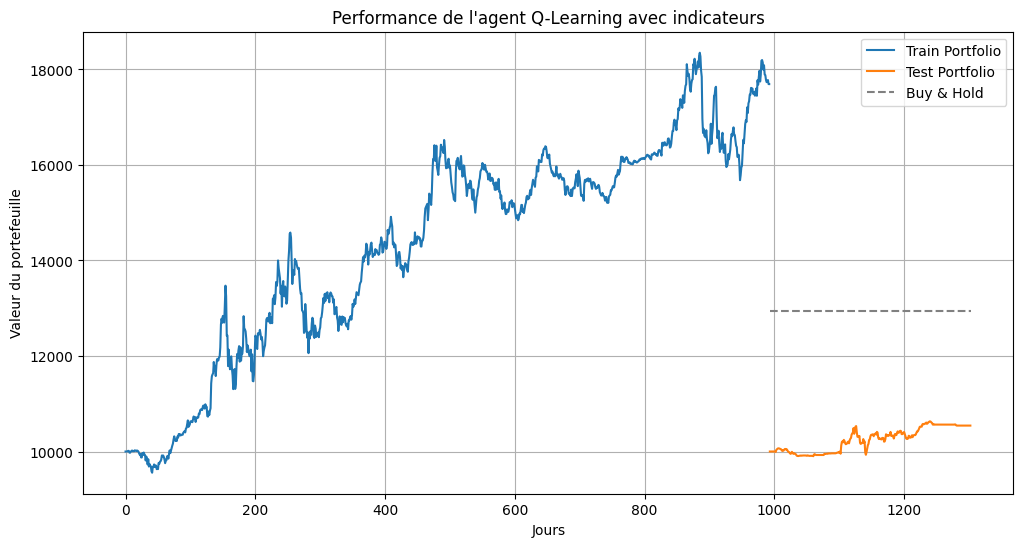

✅ Sharpe Ratio (test): 0.86
💰 Valeur finale portefeuille (test): 10542.97
📈 Buy & Hold (test): 12949.44


In [54]:
# Q-Learning Trading Agent for AAPL with Technical Indicators

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from collections import defaultdict

# ---------------------------
# Chargement et enrichissement des données avec indicateurs techniques
# ---------------------------

df = pd.read_csv("data/apple_data_normalized.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)

# RSI
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

df['RSI'] = compute_rsi(df['Close'])

# MACD
ema_12 = df['Close'].ewm(span=12, adjust=False).mean()
ema_26 = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = ema_12 - ema_26

# Moyenne mobile simple sur 10 jours
df['SMA_10'] = df['Close'].rolling(window=10).mean()

# Trend & variation
df['Return'] = df['Close'].pct_change().fillna(0)
df['Price_Trend'] = (df['Close'] > df['Open']).astype(int)

# Binnings
for col in ['Close', 'Volume', 'RSI', 'MACD']:
    df[f'{col}_bin'] = pd.qcut(df[col].bfill(), 5, labels=False)

df.dropna(inplace=True)

# ---------------------------
# Split train / test
# ---------------------------

train_df = df[df['Year'] < 2024].copy()
test_df = df[df['Year'] >= 2024].copy()

# ---------------------------
# Environnement de trading enrichi
# ---------------------------

class TradingEnv:
    def __init__(self, data):
        self.data = data.reset_index(drop=True)
        self.reset()

    def reset(self):
        self.index = 0
        self.cash = 10000
        self.stock = 0
        self.done = False
        self.prev_value = self.cash
        return self._get_state()

    def _get_state(self):
        idx = min(self.index, len(self.data) - 1)
        row = self.data.iloc[idx]
        return (
            row['Close_bin'], row['Volume_bin'], row['Price_Trend'],
            row['RSI_bin'], row['MACD_bin']
        )

    def step(self, action):
        row = self.data.iloc[self.index]
        price = row['Close'] * 500

        if action == 1 and self.cash >= price:
            self.stock += 1
            self.cash -= price
        elif action == 2 and self.stock > 0:
            self.stock -= 1
            self.cash += price

        self.index += 1
        if self.index >= len(self.data):
            self.done = True

        state = self._get_state()
        portfolio = self.cash + self.stock * price
        reward = portfolio - self.prev_value
        self.prev_value = portfolio

        return state, reward, self.done

# ---------------------------
# Q-Learning avec ε-greedy décroissant
# ---------------------------

epsilon_start = 1.0
epsilon_min = 0.05
epsilon_decay = 0.995
epsilon = epsilon_start

alpha = 0.1
gamma = 0.95
actions = [0, 1, 2]
Q = defaultdict(lambda: np.zeros(len(actions)))

episodes = 200
for ep in range(episodes):
    env = TradingEnv(train_df)
    state = env.reset()
    done = False

    while not done:
        if np.random.rand() < epsilon:
            action = np.random.choice(actions)
        else:
            action = np.argmax(Q[state])

        next_state, reward, done = env.step(action)
        Q[state][action] += alpha * (reward + gamma * np.max(Q[next_state]) - Q[state][action])
        state = next_state

    epsilon = max(epsilon * epsilon_decay, epsilon_min)

# Sauvegarde du Q-table
with open("q_table.pkl", "wb") as f:
    pickle.dump(dict(Q), f)

# ---------------------------
# Evaluation
# ---------------------------

def evaluate(env_data):
    env = TradingEnv(env_data)
    state = env.reset()
    portfolio_values = []

    while not env.done:
        action = np.argmax(Q[state])
        _, _, _ = env.step(action)
        price = env_data.iloc[min(env.index, len(env_data)-1)]['Close'] * 500
        portfolio = env.cash + env.stock * price
        portfolio_values.append(portfolio)
        state = env._get_state()

    return portfolio_values

portfolio_train = evaluate(train_df)
portfolio_test = evaluate(test_df)

# Strategie Buy & Hold
initial_price = test_df.iloc[0]['Close'] * 500
final_price = test_df.iloc[-1]['Close'] * 500
buy_hold_value = 10000 * (final_price / initial_price)

# ---------------------------
# Affichage
# ---------------------------

plt.figure(figsize=(12, 6))
plt.plot(portfolio_train, label="Train Portfolio")
plt.plot(np.arange(len(portfolio_train), len(portfolio_train)+len(portfolio_test)), portfolio_test, label="Test Portfolio")
plt.hlines(buy_hold_value, len(portfolio_train), len(portfolio_train)+len(portfolio_test), colors='gray', linestyles='dashed', label='Buy & Hold')
plt.xlabel("Jours")
plt.ylabel("Valeur du portefeuille")
plt.title("Performance de l'agent Q-Learning avec indicateurs")
plt.legend()
plt.grid(True)
plt.show()

# ---------------------------
# Indicateurs
# ---------------------------

def sharpe_ratio(returns, risk_free_rate=0):
    excess_returns = returns - risk_free_rate
    return_ratio = np.mean(excess_returns)
    std_ratio = np.std(excess_returns)
    return (return_ratio / std_ratio) * np.sqrt(252) if std_ratio != 0 else 0

test_returns = pd.Series(portfolio_test).pct_change().dropna()
print("✅ Sharpe Ratio (test):", round(sharpe_ratio(test_returns), 2))
print("💰 Valeur finale portefeuille (test):", round(portfolio_test[-1], 2))
print("📈 Buy & Hold (test):", round(buy_hold_value, 2))